## MatrixCompletionClass

1) Generates random matrix with certain rank
2) Removes entries (missing_fraction parametr)
3) Adds Gaussian noise to non-missing entries (noise_lvl parametr)
4) Completes matrix



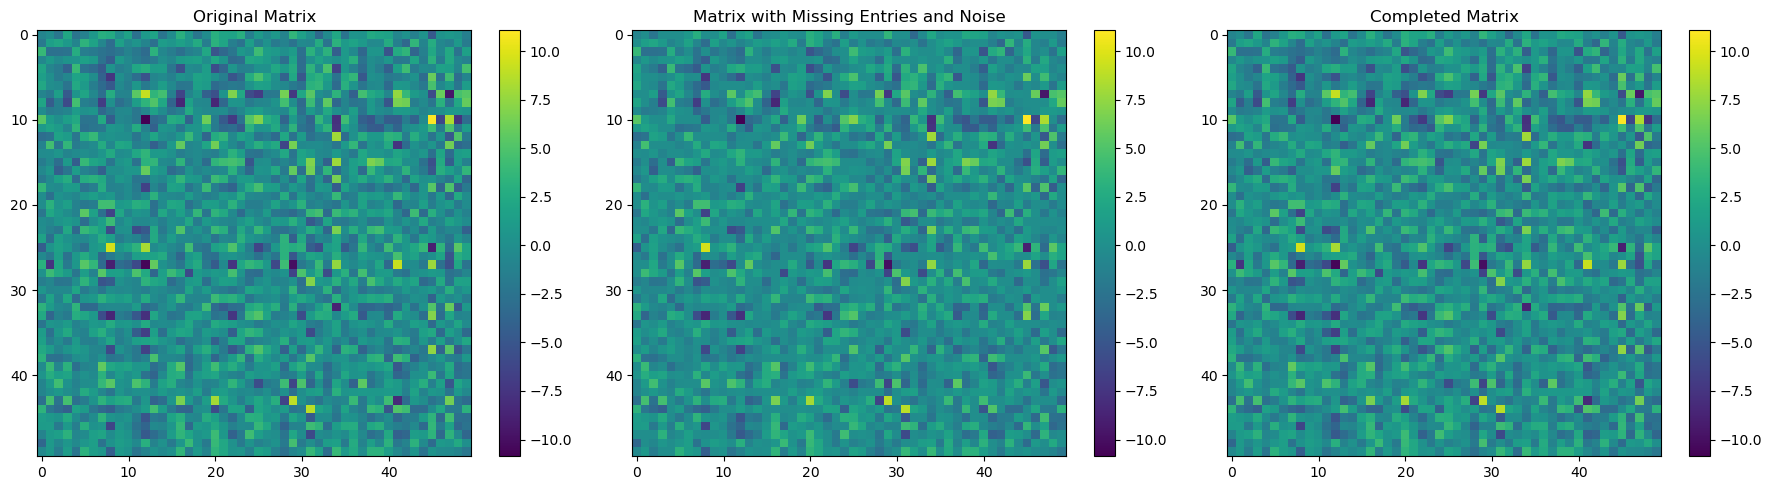

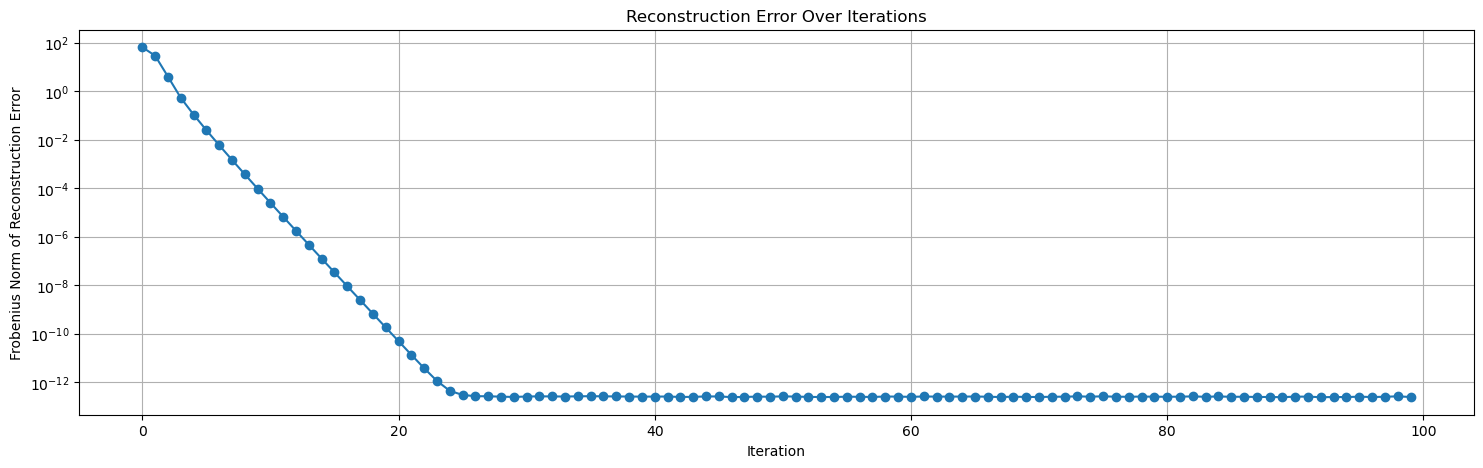

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import json

from MatrixCompletionClass import MatrixCompletion


params_str = json.dumps({
    "m": 50,                 # Number of rows
    "n": 50,                 # Number of columns
    "rank": 6,              # Rank of the original matrix
    "missing_fraction": 0.2, # 50% of the entries will be missing
    "noise_level": 0,        # Standard deviation of Gaussian noise
    "num_iters": 100,        # Maximum number of iterations for completion
    "tol": 1e-9,             # Convergence tolerance, np.inf if it not need
})

simulator = MatrixCompletion(params_str)
simulator.run()

simulator.plot_matrices()
simulator.plot_error_iteration()

## New class

1) Inherit from class MatrixCompletion
2) write to _init_ super().__init__(params_str) and after that add some new required parametrs
3) rewrite funciton complete_matrix with appending error and time history

In [4]:
import numpy as np
import pandas as pd
import time

class MatrixCompletionSVD(MatrixCompletion):
    def __init__(self, params_str):
        super().__init__(params_str) # getting old parametrs

        # params_json is saved json of parametrs
        self.tau = self.params_json.get('tau', 0.5) # adding new parametr

    def complete_matrix(self):
        # оно не работает, просто для примера
        tau = self.tau
        m, n = self.M_noisy.shape
        U = np.random.randn(m, self.rank)
        V = np.random.randn(n, self.rank)
        M_filled = np.nan_to_num(self.M_noisy)
        self.history = []
        self.time = []

        start_time = time.time()
        for it in range(self.num_iters):
            # Update U
            for i in range(m):
                V_i = V[self.M_mask[i, :], :]  # Observed entries in row i
                M_i = M_filled[i, self.M_mask[i, :]]
                if V_i.size == 0:
                    continue
                # Solve least squares: minimize ||U[i]V_i^T - M_i||^2 + lambda_reg ||U[i]||^2
                U[i, :] = np.linalg.lstsq(V_i, M_i, rcond=None)[0]
            
            # Update V
            for j in range(n):
                U_j = U[self.M_mask[:, j], :]  # Observed entries in column j
                M_j = M_filled[self.M_mask[:, j], j]
                if U_j.size == 0:
                    continue
                # Solve least squares: minimize ||U_j V[j] - M_j||^2 + lambda_reg ||V[j]||^2
                V[j, :] = np.linalg.lstsq(U_j, M_j, rcond=None)[0]
            
            # Compute current approximation
            M_current = U @ V.T

            # Calculate (e)rror obligatory part)
            error = np.linalg.norm((M_current - M_filled)[self.M_mask])
            self.error_history.append(error)
            self.time_history.append(time.time() - start_time)

        self.M_completed = U @ V.T

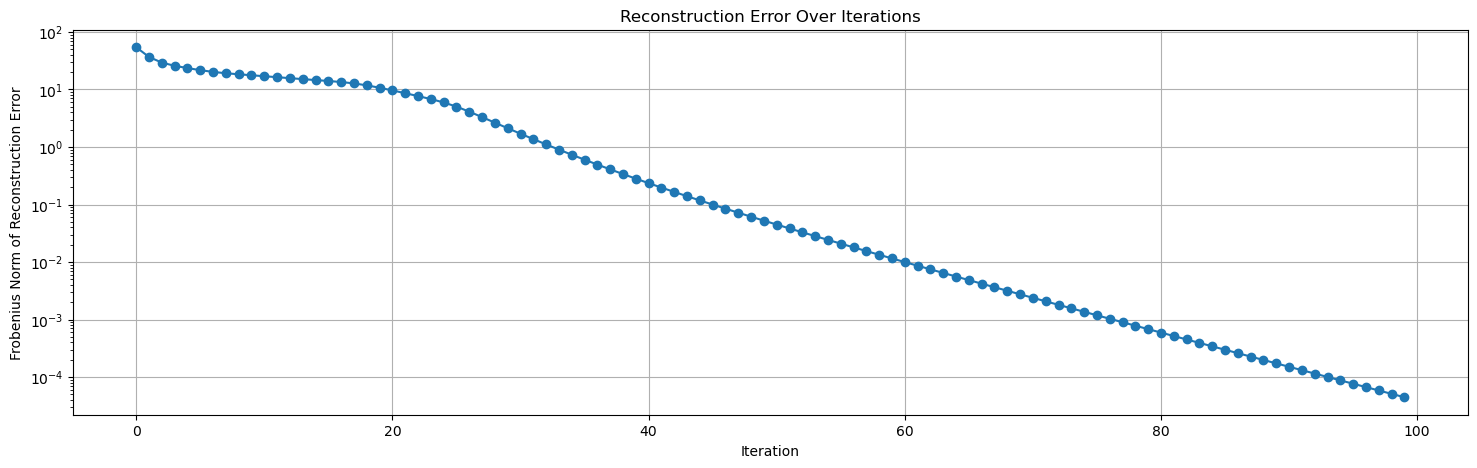

In [6]:
params_str = json.dumps({
    "m": 50,                 # Number of rows
    "n": 50,                 # Number of columns
    "rank": 10,              # Rank of the original matrix
    "missing_fraction": 0.5, # 50% of the entries will be missing
    "noise_level": 0,        # Standard deviation of Gaussian noise
    "num_iters": 100,        # Maximum number of iterations for completion
    "tol": 1e-9,             # Convergence tolerance, np.inf if it not need

    "tau": 0.33           # Another custom parametrs
})

simulator = MatrixCompletionSVD(params_str)
simulator.run()

simulator.plot_error_iteration()

## Comparison class

To simulate several algorithm with parametr grid

1) simulators -- list of simulators that would testin silumation
2) const parametrs -- some unchangebale parametrs in all simulations
3) parameter_grids -- parametr which can vary 

In [7]:
from ComparisonSimulatorClass import ComparisonSimulation

simulators = [
    MatrixCompletion, 
    MatrixCompletionSVD
    ]

const_parameters = {
    "m": 100,
    "n": 100,
    "num_iters": 200,
}

parameter_grids = {
    "noise_level": [0.1],
    "rank": [15],
    "missing_fraction": [0.7],
    "tau": [1, 3, 5]  # for MatrixCompletionSVD
}

simulation = ComparisonSimulation(
    simulators=simulators,
    const_params=const_parameters,
    varying_params=parameter_grids
)

simulation.run_sumulation()
results_df = simulation.get_results()


Simulators: 100%|██████████| 2/2 [00:06<00:00,  3.18s/it]


At the end of simulation we have a df with all results

In [8]:
results_df.head()

,simulator,noise lvl,rank,missing_fraction,tau,error,time,iteration
0,MatrixCompletion,0.1,15,0.7,1,104.904,0.017096,0
0,MatrixCompletion,0.1,15,0.7,1,64.499557,0.025686,1
0,MatrixCompletion,0.1,15,0.7,1,50.176447,0.034059,2
0,MatrixCompletion,0.1,15,0.7,1,43.195049,0.040115,3
0,MatrixCompletion,0.1,15,0.7,1,38.822795,0.04624,4


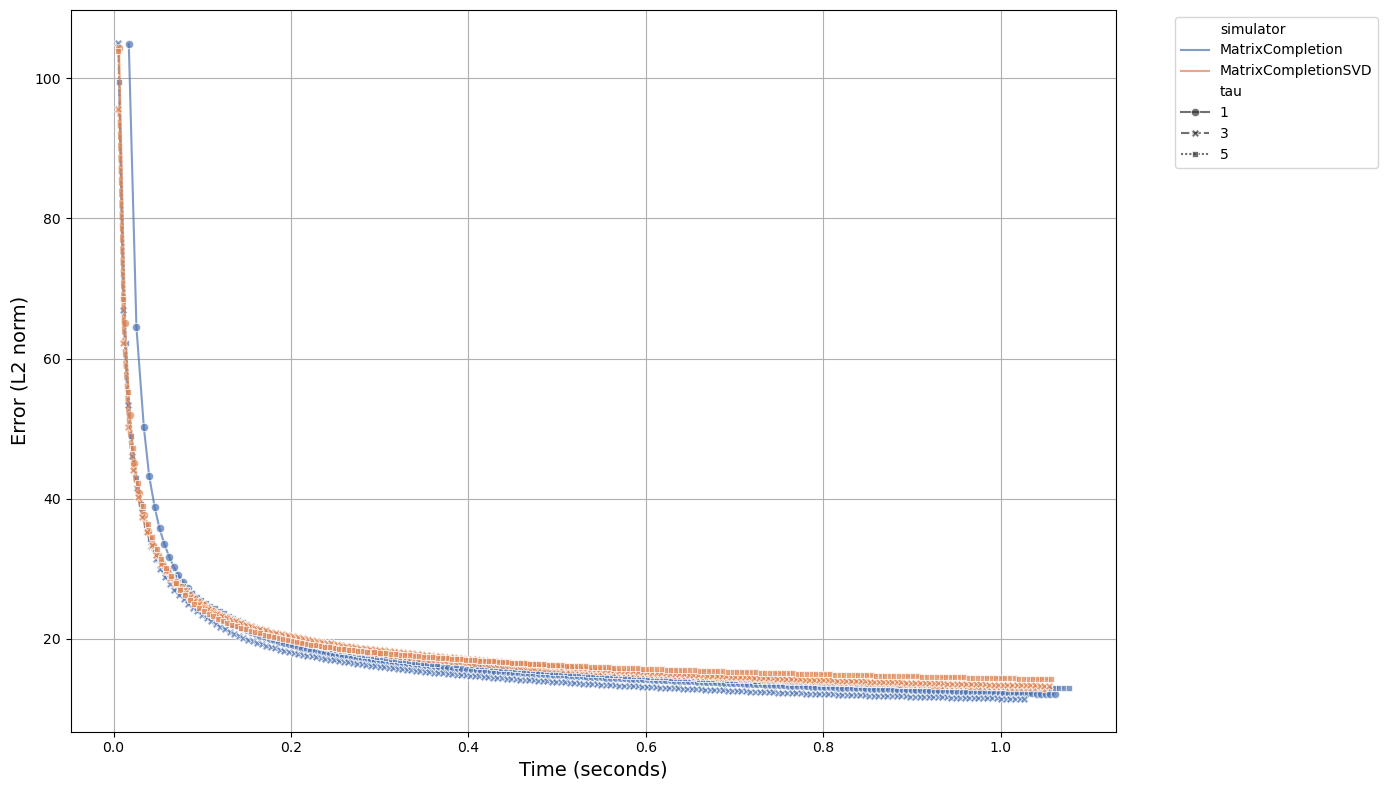

In [9]:
from plots import plot_error_vs_time

plot_error_vs_time(results_df, marker_param='tau')